In [5]:
import pandas as pd
import numpy as np
from collections import Counter
import re

### **Problema 1 -  Word Cloud**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/tw_source.csv/tw_source.csv',
                    encoding='latin_1', header=None)
dataset.columns = ['valor', 'id', 'fecha', 'fuente', 'usuario', 'tweet']
dataset.head()

,valor,id,fecha,fuente,usuario,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Usuarios Populares**

In [ ]:
lista_menciones = []

for tweet in dataset['tweet']:
  ats_in_tweet = [palabra for palabra in tweet.split(' ') if '@' in palabra]
  lista_menciones.extend(ats_in_tweet)

In [ ]:
contador_menciones = Counter(lista_menciones)
contador_menciones.most_common(4)[1:]

[('@mileycyrus', 4310), ('@tommcfly', 3837), ('@ddlovato', 3349)]

**Corpus**

In [ ]:
dataset['menciones'] = dataset['tweet'].apply(lambda x: re.findall(r'@\w+', x))

mentions_expanded = dataset.explode('menciones')

populares = mentions_expanded['menciones'].value_counts().head(3)

In [ ]:
listapopulares = populares.index.tolist()

# Realizar el filtro de los tweets que mencionan a los usuarios
corpus = {}

for user in listapopulares:
    usuario_tweets = mentions_expanded[mentions_expanded['menciones'] == user]

    # Se crea el dataframe
    usuario_corpus = usuario_tweets[['id', 'fecha', 'tweet']]
    usuario_corpus['Length'] = usuario_corpus['tweet'].apply(len)


    corpus[user] = usuario_corpus

    # Mostrar la información
    print(f"Información de {user}:")
    print(usuario_corpus.head(), "\n")

<ipython-input-25-716d225382bd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuario_corpus['Length'] = usuario_corpus['tweet'].apply(len)
<ipython-input-25-716d225382bd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuario_corpus['Length'] = usuario_corpus['tweet'].apply(len)


Información de @mileycyrus:
              id                         fecha  \
1021  1468063101  Mon Apr 06 23:30:57 PDT 2009   
2014  1468286517  Tue Apr 07 00:45:20 PDT 2009   
2073  1468297110  Tue Apr 07 00:49:07 PDT 2009   
2080  1468298918  Tue Apr 07 00:49:44 PDT 2009   
2156  1468318249  Tue Apr 07 00:56:41 PDT 2009   

                                                  tweet  Length  
1021  @mileycyrus hahaha dont be like that one time ...     107  
2014  @mileycyrus i have the same problem, but it's ...     137  
2073  @mileycyrus I guess counting sheep didn't work...      72  
2080  @mileycyrus I would too if it meant spending a...     100  
2156  @mileycyrus AWWW u seriously have the cutest d...     112   

Información de @tommcfly:
              id                         fecha  \
1690  1468210813  Tue Apr 07 00:19:09 PDT 2009   
1789  1468233211  Tue Apr 07 00:26:52 PDT 2009   
2514  1468391638  Tue Apr 07 01:23:07 PDT 2009   
3029  1468502040  Tue Apr 07 02:03:41 PDT 2009 

<ipython-input-25-716d225382bd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuario_corpus['Length'] = usuario_corpus['tweet'].apply(len)


**Razon por la que citan a ese usuario**


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
# remover stopwords y aplicar lematización
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower() not in stop_words]
    return tokens

In [ ]:

usuariocontexto = {}


for user in listapopulares:
    usuario_tweets = corpus[user]['tweet'].tolist()
    context_words = []

    for tweet in usuario_tweets:
        tokens = preprocess_text(tweet)
        if user.strip('@') in tokens:
            user_index = tokens.index(user.strip('@'))
            context_words.extend(tokens[max(0, user_index-5):user_index])
            context_words.extend(tokens[user_index+1:min(len(tokens), user_index+4)])

    usuariocontexto[user] = Counter(context_words)


    print(f"Palabras comunes para el usuario: {user}:")
    print(usuariocontexto[user].most_common(10), "\n")

Palabras comunes para el usuario: @mileycyrus:
[('miley', 572), ('http', 490), ('love', 391), ('u', 207), ('good', 187), ('hey', 173), ('quot', 173), ('hope', 138), ('vote', 134), ('come', 132)] 

Palabras comunes para el usuario: @tommcfly:
[('tom', 561), ('say', 190), ('http', 182), ('hey', 154), ('u', 147), ('please', 142), ('good', 138), ('love', 122), ('guy', 108), ('reply', 102)] 

Palabras comunes para el usuario: @ddlovato:
[('demi', 430), ('love', 246), ('http', 182), ('u', 173), ('wish', 170), ('hey', 120), ('come', 114), ('hope', 109), ('im', 108), ('please', 104)] 



**Mostrar Wordcloud**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

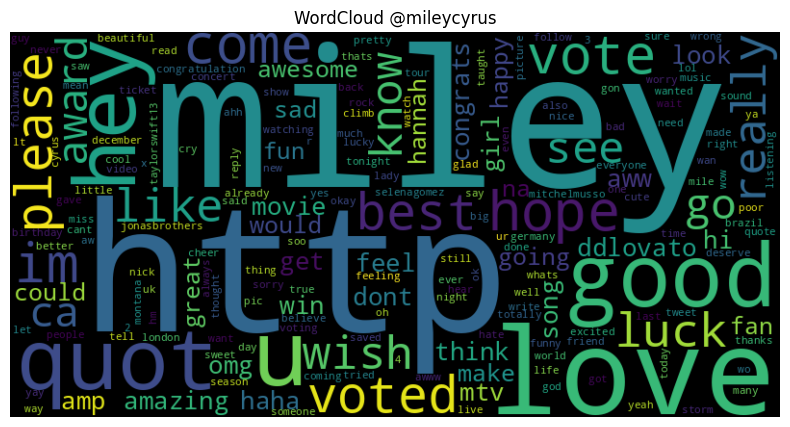

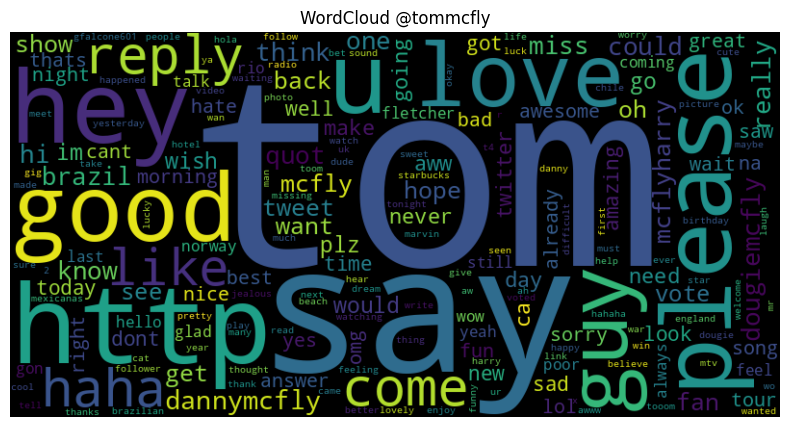

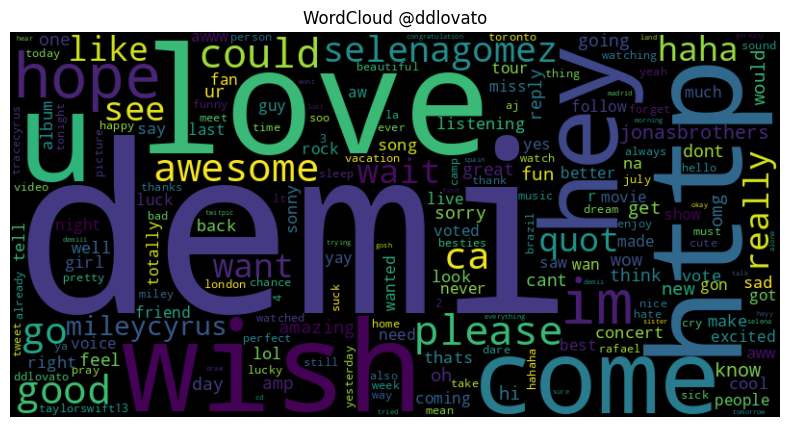

In [ ]:


def generate_wordcloud(contadortexto, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(contadortexto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for user in listapopulares:
    generate_wordcloud(usuariocontexto[user], f"WordCloud {user}")

## Problema 2

**Parte 1**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [12]:
# Generador de datos
t_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cargar imágenes
generator_entren = t_datagen.flow_from_directory(
    '/content/drive/MyDrive/tw_source.csv/Fruits_Vegetables_Dataset(12000)/Fruits',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5988 images belonging to 10 classes.


In [13]:
from tensorflow.keras import layers, models

# Red neuronal convolucional
modelo = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases: 5 frutas y 5 vegetales
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
modelo.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenar el modelo con el generador de datos
history = modelo.fit(
    generator_entren,
    steps_per_epoch=100,
    epochs=2,
    validation_steps=50
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.1271 - loss: 2.2569
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.3220 - loss: 1.8953


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [15]:
print(generator_entren.num_classes)

10


**Parte 2**

In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Dividir conjunto de datos

t_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25  # 25% de los datos para validación
)

# Conjunto de entrenamiento y validación
train_generator = t_datagen2.flow_from_directory(
    '/content/drive/MyDrive/tw_source.csv/Fruits_Vegetables_Dataset(12000)/Vegetables',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = t_datagen2.flow_from_directory(
    '/content/drive/MyDrive/tw_source.csv/Fruits_Vegetables_Dataset(12000)/Vegetables',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4503 images belonging to 10 classes.
Found 1495 images belonging to 10 classes.


In [21]:
from tensorflow.keras import layers, models

model1 = models.Sequential()

# Primera capa convolucional
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Capa completamente conectada
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
 11/141 ━━━━━━━━━━━━━━━━━━━━ 18:29 9s/step - accuracy: 0.1429 - loss: 3.1211

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1660s 11s/step - accuracy: 0.2836 - loss: 2.0825 - val_accuracy: 0.4789 - val_loss: 1.3704
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5268 - loss: 1.2687 - val_accuracy: 0.6783 - val_loss: 0.9629
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6322 - loss: 1.0283 - val_accuracy: 0.6990 - val_loss: 0.8460
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6826 - loss: 0.8832 - val_accuracy: 0.7070 - val_loss: 0.8097
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7184 - loss: 0.7955 - val_accuracy: 0.7244 - val_loss: 0.8277


KeyboardInterrupt: 

In [22]:
modelo2 = models.Sequential()

# Primera capa convolucional
modelo2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
modelo2.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
modelo2.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo2.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
modelo2.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelo2.add(layers.MaxPooling2D((2, 2)))

# Cuarta capa convolucional
modelo2.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelo2.add(layers.MaxPooling2D((2, 2)))

# Capa completamente conectada
modelo2.add(layers.Flatten())
modelo2.add(layers.Dense(512, activation='relu'))
modelo2.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compilar el modelo
modelo2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
modelo3 = models.Sequential()

# Primera capa convolucional
modelo3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
modelo3.add(layers.MaxPooling2D((2, 2)))

# Segunda capa convolucional
modelo3.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo3.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
modelo3.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelo3.add(layers.MaxPooling2D((2, 2)))

# Dropout para regularización
modelo3.add(layers.Dropout(0.5))

# Capa completamente conectada
modelo3.add(layers.Flatten())
modelo3.add(layers.Dense(512, activation='relu'))
modelo3.add(layers.Dropout(0.5))  # Otra capa Dropout
modelo3.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compilar el modelo
modelo3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:


# Entrenar la Arquitectura 2
history2 = modelo2.fit(train_generator, epochs=10, validation_data=validation_generator)

# Entrenar la Arquitectura 3
history3 = modelo3.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.2465 - loss: 2.0261 - val_accuracy: 0.5110 - val_loss: 1.3503
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4816 - loss: 1.3820 - val_accuracy: 0.5251 - val_loss: 1.3137
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.5580 - loss: 1.1915 - val_accuracy: 0.6321 - val_loss: 1.0861
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6322 - loss: 0.9987 - val_accuracy: 0.6421 - val_loss: 0.9652
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6740 - loss: 0.8853 - val_accuracy: 0.7070 - val_loss: 0.8623
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7018 - loss: 0.8335 - val_accuracy: 0.7043 - val_loss: 0.8646
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7293 - loss: 0.7787 - val_accuracy: 0.7224 - val_loss: 0.8100
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7388 - loss: 0.7318 - val_accu

In [29]:
# Evaluar las tres arquitecturas
test_loss1, test_acc1 = model1.evaluate(validation_generator)
test_loss2, test_acc2 = modelo2.evaluate(validation_generator)
test_loss3, test_acc3 = modelo3.evaluate(validation_generator)

print(f"Model 1 - Test Accuracy: {test_acc1}")
print(f"Model 2 - Test Accuracy: {test_acc2}")
print(f"Model 3 - Test Accuracy: {test_acc3}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.7153 - loss: 0.8674
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 556ms/step - accuracy: 0.7498 - loss: 0.7347
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 552ms/step - accuracy: 0.7489 - loss: 0.7361
Model 1 - Test Accuracy: 0.7137123942375183
Model 2 - Test Accuracy: 0.7464882731437683
Model 3 - Test Accuracy: 0.7438126802444458


El modelo 2 tiene la mejor precisión por muy poco debido a que cuenta con mayor cantidad de capas y estas capturan mas caracteristicas. El tercer modelo esta muy cerca de ser el seleccionado solo se deberia de analizar si se regulariza el sobre ajuste.